# S&P500 Sector Analysis: Healthcare & Technology

##### Andre Tom, Michael Ash, and Derek Mitchler

The launch of the first ETF in the 90's and the advances in statistical modeling applied to financial situations over the same time period have led to drastic changes in the financial world over the past 20 years. As more and more talented individuals flood the market, opportunities for Alpha are becoming more and more scarce. One only has to look at Hedge Fund performance since the '08 crash to notice the diminishing returns and outflows of capital from the sector. Managers of active funds are losing clients to two newly trending strategies: quantitative and passive investing. [1]

We seek to understand how these strategies can be applied in a day-to-day manner while seeking Alpha. As such, we'll analyze a handful of State Street ETF's [2], commonly referred to as SPDR ETFs, that mirror the S&P500 index, as well as the Healthcare and Technology sector and their corresponding industries. In the following report we will take advantage of statistical tools to:

1) Explain and illustrate the concept of technical (opposed to fundamental) analysis applied to equities.

2) Discuss the theory of portfolio optimization and the Efficient Frontier.

3) Look at and experiment with how statistical methods are being applied to financial scenarios to generate Alpha.

In [40]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
''')

In [1]:
# libraries for analysis
import numpy as np
import pandas as pd
from projectworkflow.data import *
from projectworkflow.lstm import *

# libraries for visualization
import seaborn as sns
import matplotlib.pyplot as plt

# database allocation
import requests_cache

import time
import math
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

from projectworkflow.nytimes import *

import nltk
import nltk.corpus
from nltk.corpus import wordnet

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(style="ticks")

requests_cache.install_cache('sp500')

Using TensorFlow backend.


In [2]:
keyfile = '../keys/alpha_vantage' # alpha vantage requires an API key, which can be readily obtained
start_date = '2012-01-01' # we'll look at the last seven years of data, roughly
market=['SPY'] 
sector = ['XLK','XLV'] 
industry = ['XBI','XPH','XHS','XHE','XTL','XSD','XWEB','XTH','XSW'] 

key = read_key(keyfile)
sector_data = get_data(key, market+sector)
sector_df = create_df(sector_data, start_date, norm=True)

#### Technical indicators and EDA of Time Series Data
We begin our analysis by detailing and observing our data and also its source. We'll be making use of Alpha Vantage, The New York Times, and the US Federal Reserve for data purposes through either open APIs or web scraping technologies. Alpha Vantage, which gives access to over 20+ years of time series data through its open API [3], is particularly useful as they have not only all listed equities, but also crypto's, FX, and technical indicators that one could pull depending on the level of analysis they wished to perform. For our purposes, we'll be taking a look at the following 12 SPDR ETF's:

S&P 500, sym: SPY | Technology Sector, sym: XLK | Healthcare Sector, sym: XLV | Biotech Industry, sym: XBI | Pharmaceutical Industry, sym: XPH | Healthcare Services Industry, sym: XHS | Healthcare Equipment Industry, sym: XHE | Telecom Industry, sym: XTL | Semiconductor Industry, sym: XSD | Internet Industry, sym: XWEB | Tech Hardware Industry, sym: XTH | Computer Software Industry, sym: XSW

Note --  Alpha Vantage has a limit of 5 calls per minute (500/day) so there is a 12 second timer between calls

Plotting the market and sector ETFs first gives us a more complete macro view of what is going on, and provides insight into time periods in which anomolies may have occurred (think Brexit, elections, wars, etc.) that would affect the overall market trends. We've normalized the growth to better illustrate the relation between sector and market. A couple things to take note of:

1) We can see when the economy / market experienced shocks, specifically in the mid to late 2015 and late 2018. The 2018 shock is more recent, and we can attribute it to the stock market loss that accompanied the government shutdown over border wall funding. 2015 seems to have been a generally volatile year for all markets, with the S&P closing down .7% [4]. 

2) There are apparent trends in the popularity of sectors, and we can see how those change throughout the last 6-7 years. Healthcare, once the significant overachiever, has been surpassed this past year by Technology. Healthcare also seems more volatile, which could be attributed to the difficulty in valuating pharma and biotech companies, whose worth is forecasted based off of trials / grant proposals most of the time [5].

3) This chart clearly shows the power of passive investing and index funds / ETFs. The SPY ETF, the 'worst performing' asset out of our three, still shows an average growth of 175% over its value at the beginning of our analysis, The Healthcare and Tech ETF's are even better. One can see how wealth can grow by leaving it in a passive fund, especially if you incrementally increase your position over time. 

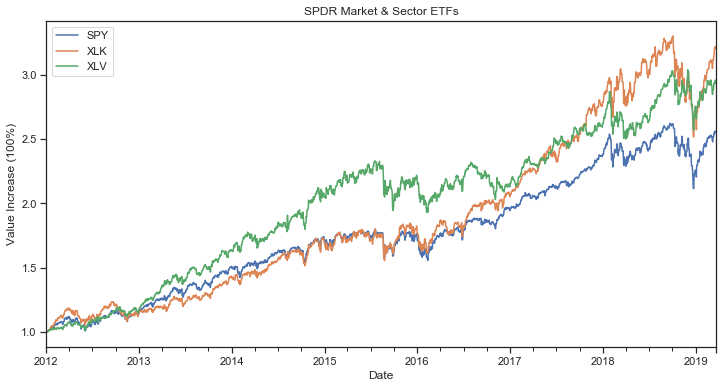

           SPY       XLK       XLV
mean  1.754796  1.885790  2.005072
std   0.445268  0.641991  0.555984
min   1.000000  1.000000  0.995161
25%   1.418809  1.334373  1.545496
50%   1.738848  1.740600  2.122586
75%   2.111011  2.370588  2.361022
max   2.624539  3.304557  3.041039


In [3]:
# we measure returns (relative) of market and sector ETF's
sector_df.plot(title='SPDR Market & Sector ETFs',figsize=(12,6))
plt.ylabel('Value Increase (100%)') # 3.0 refers to 3x or 300% returns
plt.xlabel('Date')
plt.show()
print(sector_df.describe()[1:])

As seen above, there is a clear dip in the markets in 2015 and 2018. We hypothesized that these were due to geopolitical issues, namely elections and the government shutdown. Now, we'll analyze articles from the NYT during both these periods to gain a better idea of what may have occurred. While we won't be incorporating these findings into features for our RNN, a more advanced model would have such a capability. In fact, that is one of the jobs quantitative investors perform; analyzing not only the market but how outside news and events may affect the market, and tweaking their code to accommodate such change. 

We filter our data as to avoid articles of unrelated genres (fashion, sports, food, etc.) and arrive at the following distributions:

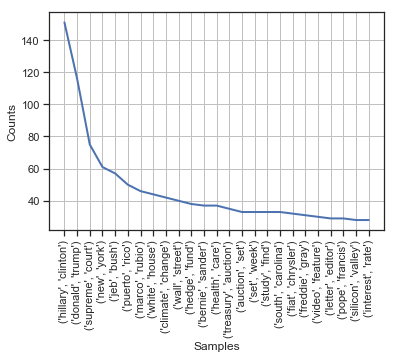

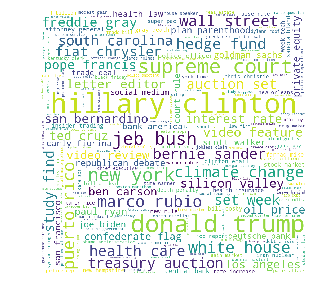

Bi-Gram: Presidential Election of 2016 | Number of Instances: 820
Bi-Gram: Mergers, Acquisitions and Divestitures | Number of Instances: 630
Bi-Gram: United States Politics and Government | Number of Instances: 540
Bi-Gram: Republican Party | Number of Instances: 475
Bi-Gram: Stocks and Bonds | Number of Instances: 430
Bi-Gram: Obama, Barack | Number of Instances: 418
Bi-Gram: Banking and Financial Institutions | Number of Instances: 391
Bi-Gram: Murders, Attempted Murders and Homicides | Number of Instances: 343
Bi-Gram: United States | Number of Instances: 342
Bi-Gram: Computers and the Internet | Number of Instances: 297


In [8]:
stopwords = nltk.corpus.stopwords.words("english")
stopwords += ['say', 'go', 'get', 'would', 'could', 'also', 'one']
stopwords = set(stopwords).union(STOPWORDS)

key2 = read_key("../keys/nyt")
article_df = get_articles_date_range(key2, '2015-5', '2015-12')
articles = clean_article_df(article_df)
headline_words = clean_tokenize(articles['headline'], stopwords)
headline_bigrams = nltk.FreqDist(list(nltk.bigrams(headline_words)))

headline_bigrams_joined = {' '.join(key):value for (key, value) in headline_bigrams.items()}

headline_bigrams.plot(25)
article_keywords = Counter(x for sublist in articles['keywords'] for x in sublist)
article_keywords_dict = dict(article_keywords)
word_freq_cloud(headline_bigrams_joined, stopwords)
b_gram = article_keywords.most_common(10)
for a in b_gram:
    x,y = a
    print("Bi-Gram: {} | Number of Instances: {}".format(x,y))

From 2015 we can see that the top word pairs seem to be related mainly to the US government and the election going on between Donald Trump and Hillary Clinton. While these words are useful for a very vague picture, to create features based off of these results would require us to dig deeper into the data, most likely expanding our set of words that we'd eliminate from any analysis. 

Next, we take a look at the other instability caused, the 2018 dip. We can see below that once again, politics and the drama in Washington seems to be at the center of what was going on. The shutdown, recent midterm elections, and the ongoing investigation into the 2016 were all prevelant topics leading into the end of 2018. Again it is worth noting that, while these findings support our hypothesis for the downturn in the markets, they are not enough to construct features for use in our prediction model. We'd once again need to dig deeper into NLP tools, a task that is outside the thesis of this analysis. 

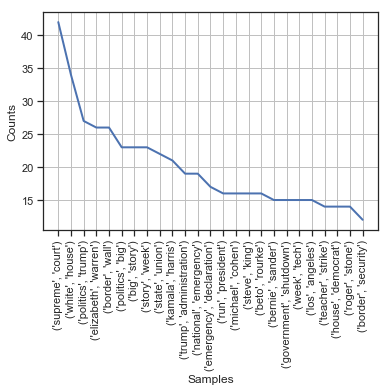

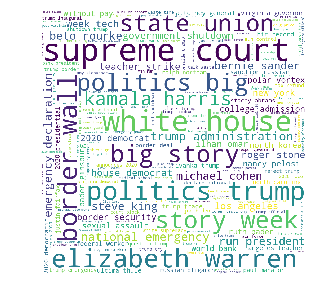

Bi-Gram: United States Politics and Government | Number of Instances: 1120
Bi-Gram: Trump, Donald J | Number of Instances: 756
Bi-Gram: Democratic Party | Number of Instances: 374
Bi-Gram: Shutdowns (Institutional) | Number of Instances: 232
Bi-Gram: Presidential Election of 2020 | Number of Instances: 221
Bi-Gram: House of Representatives | Number of Instances: 203
Bi-Gram: Republican Party | Number of Instances: 162
Bi-Gram: Immigration and Emigration | Number of Instances: 162
Bi-Gram: Border Barriers | Number of Instances: 162
Bi-Gram: Russian Interference in 2016 US Elections and Ties to Trump Associates | Number of Instances: 161


In [9]:
article_df2 = get_articles_date_range(key2, '2018-1', '2019-3')
articles2 = clean_article_df(article_df2)
headline_words2 = clean_tokenize(articles2['headline'], stopwords)
headline_bigrams2 = nltk.FreqDist(list(nltk.bigrams(headline_words2)))
headline_bigrams_joined2 = {' '.join(key):value for (key, value) in headline_bigrams2.items()}
headline_bigrams2.plot(25)

word_freq_cloud(headline_bigrams_joined2, stopwords)
article_keywords2 = Counter(x for sublist in articles2['keywords'] for x in sublist)
article_keywords2_dict = dict(article_keywords2)
b_gram2 = article_keywords2.most_common(10)

for a in b_gram2:
    x,y = a
    print("Bi-Gram: {} | Number of Instances: {}".format(x,y))

We get back to our financial data, and display some summary statistics for our sector ETF's. From a basic quartile plot, we can get an idea of an assets history of performance. Notice that the Tech ETF is primarily clustered from 1 to 2 (100% returns) while Healthcare and S&P seem to be more consistently even. This can give us an idea of the volatility of a stock, as the tech sector's standard deviation is higher than the others due to its increased rate of return over the past year.

In [10]:
sector_df.describe()[1:]

,SPY,XLK,XLV
mean,1.754796,1.885790,2.005072
std,0.445268,0.641991,0.555984
min,1.000000,1.000000,0.995161
25%,1.418809,1.334373,1.545496
50%,1.738848,1.740600,2.122586
75%,2.111011,2.370588,2.361022
max,2.624539,3.304557,3.041039


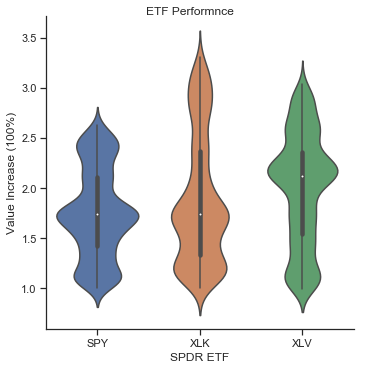

In [4]:
g = sns.catplot(data=sector_df, kind="violin")
g.fig.suptitle('ETF Performnce')
g.set_axis_labels(x_var='SPDR ETF', y_var='Value Increase (100%)')
plt.show()

We now introduce technical factors and the use of Bollinger Bands in the analysis of an asset. Technical analysis refers to the strategy of garnering statistical trends from gathered market data, generally stock price and volume. Bollinger Bands are a popular metric that plots an asset's moving average over a period of days, along with intervals equal to some scalar factor of the standard deviation. [6]

The idea behind the bands is that the day to day price movement breaking the upper bounds is a sign that the stock has hit a peak and one should sell, while a breach of the lower bounds would suggest the price is about to rise and one should buy. From the bands below, it seems like our healthcare ETF has been fairly volatile as of late, with what looks like a decenly sized upper breach around December of 2018, coindicing with the market downturn we saw in the previous graph. 

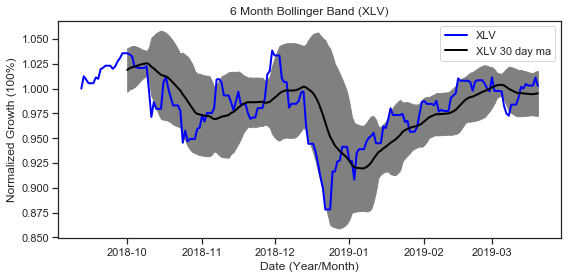

In [11]:
XLV_90 = sector_df[['XLV']][-190:]  # we'll compute a Bollinger Band for the Healthcare sector ETF
XLV_90 = bollinger(XLV_90)

fig,ax = plt.subplots(figsize=(9,4))

x_axis = XLV_90.index.get_level_values(0)
ax.fill_between(x_axis, XLV_90['XLV upper band'], XLV_90['XLV lower band'], color='grey')

ax.plot(x_axis, XLV_90['XLV'], color='blue', lw=2)
ax.plot(x_axis, XLV_90['XLV 30 day ma'], color='black', lw=2)

ax.set_title('6 Month Bollinger Band (XLV)')
ax.set_xlabel('Date (Year/Month)')
ax.set_ylabel('Normalized Growth (100%)')
ax.legend()
plt.show()

Finally, a useful metric to have for any asset is whether it's correllated to the others in your portfolio. Generally, this is given by the Beta variable, though we did not obtain that for the purpose of this analysis. Generally, Beta measures how a particular asset will fair, given how he market fairs. 

In our case, our three ETF's are very correlated, which makes sense as the sector ETF's are in essence contained in the market ETF (not perfectly but high multicolinearity). Diversifying our portfolio would be an ideal strategy to hedge against risk and bring down the volatility of our portfolio. 

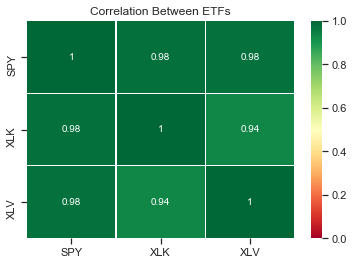

In [12]:
sns.heatmap(sector_df.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)
plt.title('Correlation Between ETFs')
plt.show()

#### Efficient Portfolio Allocation

We next turn our attention to portfolio allocation, the Efficient Frontier, and the creation of an optimized portfolio based off of our ETFs above. A portfolio is a collection of assets that one invests in, assigning different weights to different assets depending on some pre-defined preference. In our analysis, we seek to maximize returns while minimizing risk (volatility). To achieve this, we optimize our allocation to maximize our portfolio's Sharpe Ratio: 

$$ Sharpe = \frac{Returns_{expected}-Risk Free Rate}{Volatility_{expected}}$$ 

Portfolio allocation theory deals with the question of how can we assign weights to our assets as to maximize returns for a given level of volatility. The Efficient Frontier is a visual representation of phenom. Every possible combination of risky assets can be plotted in the 'risk expected return space', the hyperbola. The upper edge of this hyperbola is the efficient frontier in the absence of a risk free asset. The line running tangent to the hyperbola represents the Capital Allocation Line, whose slope measures the additional return one receives from taking on more risk. [7] 

In [13]:
investment = 1000000
alist = [x+1 for x in range(len(industry))]
w0 = [x / np.sum(alist) for x in alist]

# create df and portfolio
industry_data = get_data(key, industry)
industry_df = create_df(industry_data, start_date)
portfolio, portfolio_statistics = create_portfolio(industry_df, investment, w0)

# normalize for clearer understanding of returns
norm_df = industry_df / industry_df.iloc[0,:]
norm_port = portfolio / portfolio[0]

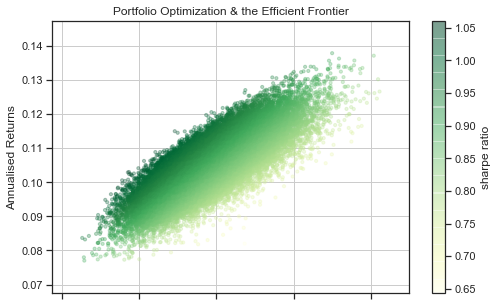

In [14]:
num_assets = len(industry)
num_port = 40000
ef = EF(industry_df, num_assets, num_port)

ef.plot.scatter(x='volatility', y='returns', c='sharpe ratio',
                cmap='YlGn', marker='o', s=10, alpha=0.3,
                   figsize=(8, 5), grid=True)

plt.title("Portfolio Optimization & the Efficient Frontier")
plt.xlabel('Annualised Volatility')
plt.ylabel('Annualised Returns')
plt.show()

We construct a portfolio comprised of our ETF's and look at the difference in returns between them. It's apparent immediately that while our portfolio doesn't have the same performance as some of the industry ETF's, it doesn't suffer from the same volatility as said ETF's. 

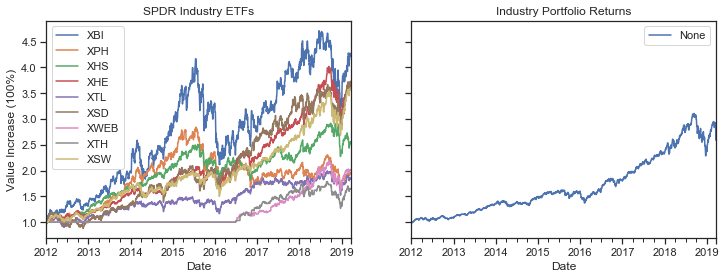

In [15]:
fig, ax = plt.subplots(1,2,figsize=(12,4),sharey=True)
norm_df.plot(title='SPDR Industry ETFs',ax=ax[0])
ax[0].set_ylabel('Value Increase (100%)')
ax[0].set_xlabel('Date')

norm_port.plot(title='Industry Portfolio Returns',ax=ax[1],legend=True)
ax[1].set_ylabel('Returns (100%)')
ax[1].set_xlabel('Date')

plt.show()

We can plot our portfolio returns against the sector and market funds to see a better idea of how the perform against a more 'stable' competitor. We can see that our optimization algorithm decided to only invest in 5 of the 9 stocks in our domain, to get a cumulative return of almost 2x. 

cumulative returns: 1.59
average daily returns: 0.0
average daily standard dev: 0.007
sharpe ratio: 0.021
allocation: [0.    0.    0.    0.407 0.    0.007 0.194 0.2   0.193]


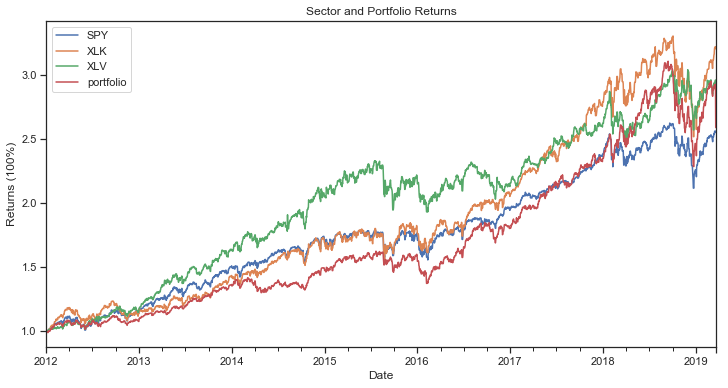

In [16]:
for key,value in portfolio_statistics.items():
    print("{}: {}".format(key, np.around(value,3)))

port_df = norm_port.to_frame(name='portfolio')
df = sector_df.merge(port_df,left_index=True, right_index=True)

df.plot(title='Sector and Portfolio Returns', figsize=(12,6))
plt.ylabel('Returns (100%)')
plt.xlabel('Date')
plt.show()

As mentioned earlier, our portfolio performance can hinge on how diversified we are. We made note of how that was lacking in the sector and market analysis. Here, it seems that most of the assets are correlated with one another, which is in line with our thinking as we're taking industries from the same sector. There are a couple that seem to be fairly uncorrelated though which may give us an idea of types of companies to include next time to diversify even more. 

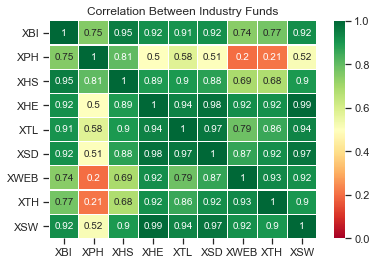

In [17]:
sns.heatmap(industry_df.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)
plt.title('Correlation Between Industry Funds')
plt.show()

#### LSTM & Time Series Forecasting

We would now like to model stock prices so we're able to decide when to buy and sell stocks to turn a profit.  We would like to analyze the history of a data sequence and attempt to predict what the future elements of that sequence will be.  Here is where a recurrent neural network (RNN), specifically a Long Short-Term Memory (LSTM) model, comes in.  
Recurrent neural newtworks differ from a traditional, or feed-forward neural net in that the information goes straight through the network; always forward, never looping back. Aptly named. Thus, a feed-foward neural network stores no information about a previous input, only concerning itself with the current input and the data its been trained on.  On the other hand, a recurrent neural network takes in an additional input of the recent past, allowing the network to loop back, making it perfect for sequential data.  However, RNN's suffer from exploding and vanishing gradient descent problems, which LSTM's fix.

Long Short-Term Memory (LSTM) networks are an extension for recurrent neural networks, which basically extends their memory. Therefore it is well suited to learn from important experiences that have very long time lags in between.[8}]  They solve the problems RNN's have by processing the information through input, forget, and output gates.  These gates allow the LSTM to learn long-term dependencies, controlling the gradient flow by keeping them steep.

Now we train and model a basic LSTM with 'simple' hyperparameters through Keras as follows:

In [18]:
test_size = .30
scale = MinMaxScaler(feature_range=(-1,1)) # range corresponds to tht of tanh
train_set, test_set = train_test_split(portfolio, test_size)

# Our input needs to be in the format of NxM matrices
train_scaled = scale.fit_transform(train_set.values.reshape(-1,1))
test_scaled = scale.fit_transform(test_set.values.reshape(-1,1))
test_x, test_y = lstm_dataset(test_scaled) # default is 1 timestep, 1 feature

# package data and params
data = [train_scaled, test_scaled]
param_base = [1,1,10,32,1] # inputs, nodes, epochs, batch size, features

# fit and predict 
lstm, history = fit_model(data, param_base)
pred = lstm.predict(test_x)

# calculate RMSE
prediction = scale.inverse_transform(pred)
test_y = scale.inverse_transform(test_y.reshape(-1,1))
root_mse = rmse(test_y, prediction)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


Model RMSE of 351435.876


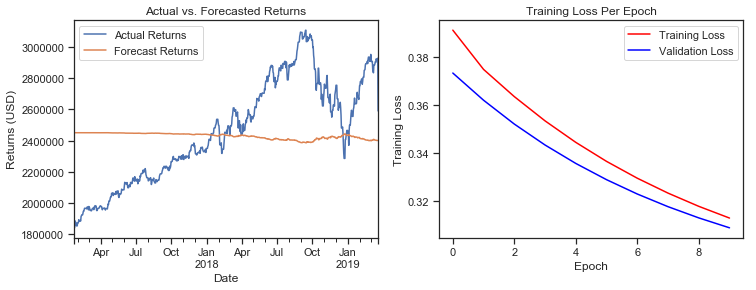

In [19]:
# plot our forecast against test data, and take a look at our MSE
real_price = portfolio[-test_y.shape[0]:].to_frame().rename({0:'Actual Returns'},axis=1)
pred_price = pd.DataFrame(prediction,index=real_price.index).rename({0:'Forecast Returns'},axis=1)
df = real_price.merge(pred_price, left_index=True, right_index=True)

# we also have the mean squared error
print("Model RMSE of {}".format(round(root_mse,3)))

fig, ax = plt.subplots(1,2,figsize=(12,4))

df.plot(title='Actual vs. Forecasted Returns',ax=ax[0])
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Returns (USD)')

ax[1].plot(history.history['loss'],color='red')
ax[1].plot(history.history['val_loss'],color='blue')
plt.title('Training Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend(labels=['Training Loss','Validation Loss'])
plt.show()

#### Grid Search
As we can see in the previous graph, the parameters we chose are incredibly inefficient, just look at the root mean squared error! We can configure optimal parameters for our model by utiizing grid-search.  Grid-Search builds a model on all permutations of the parameters given by iterating through all combinations.

In [20]:
keyfile = '../keys/alpha_vantage'
start_date = '2010-01-01'
key = read_key(keyfile)
market = ['XBI']

d = get_data(key, market)

In [22]:
#unpack the dict
df = pd.DataFrame.from_dict(d['XBI'])
df = df.T
#df.index.name = "Date"

#reversed the indexes to the correct chronological order
df = df.iloc[::-1]

#drop extra features
adj_close_df = df.drop(['1. open','2. high','3. low','4. close','6. volume','7. dividend amount','8. split coefficient'], axis=1)

#switching dataframe to series to grid search
series = pd.Series(adj_close_df['5. adjusted close'])

In [23]:
test_size = 0.3
train, test = train_test_split(series, test_size)
scale = MinMaxScaler(feature_range=(-1,1))
data = [train, test, scale]


In [24]:
inputs = [5, 10, 20, 30]
nodes = [10, 20, 30]
epochs = [10, 20, 30]
batch_size = [30, 40, 50]
features = [1]

params = parameters(inputs, nodes, epochs, batch_size, features)
#results = grid_search(data, params)

In [25]:
train_scale = scale.fit_transform(train.values.reshape(-1,1))
test_scale = scale.fit_transform(test.values.reshape(-1,1))

train_x, train_y = lstm_dataset(train_scale, 5)
test_x, test_y = lstm_dataset(test_scale, 5)

#np array isnt in the right form to feature scale
vals = adj_close_df['5. adjusted close'].values.reshape(-1,1)
vals = vals.astype('float32')

#normalize the adjusted close values to range from -1 to 1
scaled = scale.fit_transform(vals)

# plugging in the parameters we received from grid searching
rnn = Sequential([LSTM(20, input_shape=(train_x.shape[1], 1))])
rnn.add(Dropout(0.2))
rnn.add(Dense(1))

rnn.compile(optimizer='adam',loss='mse')
history = rnn.fit(train_x,train_y, epochs=30, batch_size=30, validation_data=(test_x,test_y),shuffle=False, verbose=0)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


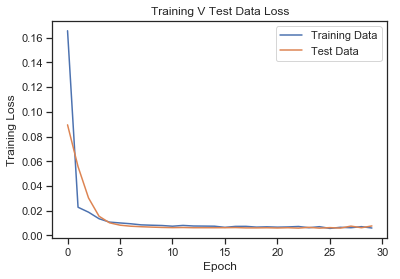

,Key,Params,Average Error
0,"[5, 20, 30, 30, 1]","[5, 20, 30, 30, 1]",2.190384
1,"[5, 10, 30, 30, 1]","[5, 10, 30, 30, 1]",2.235164
2,"[5, 20, 30, 50, 1]","[5, 20, 30, 50, 1]",2.257349
3,"[5, 20, 30, 40, 1]","[5, 20, 30, 40, 1]",2.275188
4,"[30, 20, 30, 30, 1]","[30, 20, 30, 30, 1]",2.315666
5,"[5, 20, 10, 40, 1]","[5, 20, 10, 40, 1]",2.327258
6,"[10, 20, 30, 50, 1]","[10, 20, 30, 50, 1]",2.338971
7,"[5, 10, 20, 50, 1]","[5, 10, 20, 50, 1]",2.387635


In [26]:
plt.plot(history.history['loss'],label='Training Data')
plt.plot(history.history['val_loss'], label='Test Data')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training V Test Data Loss')
plt.legend()
plt.show()

params = pd.read_csv('testing/First_GS.csv')
params[:8]

Looking at the graph, we can see at around 5 epochs, the data loss converges and the number of epochs should have little effect on the error received.  However, when looking at grid search output, the top 5 values all have epochs of 30, followed by an entry with 10 epochs.  What seems to be equally important are the time steps. Five of the top six values have time steps of 5.  Batch size has more variance in the top values returned and may not be as important when choosing parameters.  

In [27]:
# Change back to real values from normalized ones
yhat = rnn.predict(test_x)
yhat_inverse = scale.inverse_transform(yhat.reshape(-1,1))
ytest_inverse = scale.inverse_transform(test_y.reshape(-1,1))

real = adj_close_df[-test_y.shape[0]:]
pred = pd.DataFrame(yhat,index=real.index).rename({0:'Forecast Returns'},axis=1)
actual = pd.DataFrame(test_y, index=real.index).rename({0:'Actual Returns'},axis =1)
da = actual.merge(pred, left_index=True, right_index=True)

actual_l = pd.DataFrame(ytest_inverse, index=real.index).rename({0:'Actual Returns'},axis =1)
pred_l = pd.DataFrame(yhat_inverse,index=real.index).rename({0:'Forecast Returns'},axis=1)
dat = actual_l.merge(pred_l, left_index=True, right_index=True)

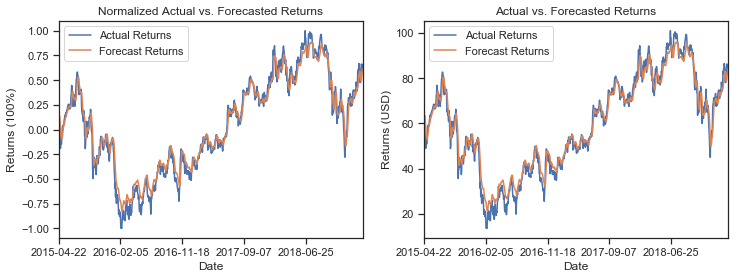

In [28]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

da.plot(title='Normalized Actual vs. Forecasted Returns',ax=ax[0])
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Returns (100%)')
# Plotting real values
dat.plot(title='Actual vs. Forecasted Returns', ax=ax[1])
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Returns (USD)')
plt.legend()
plt.show()

In [29]:
#Root Mean Squared Error
rmse = round(np.sqrt(mean_squared_error(ytest_inverse,yhat_inverse)),3)
print('Test RMSE: {0:.{1}f}'.format(rmse,3))

Test RMSE: 3.829


This RMSE is a bit higher than the average error we received from the previous grid search but we believe this is due to grid search returning an average value, rather than a single one. 

#### MultiVariate Time Series
Predicting stocks is a tricky business.  Throughout this experiment, we have predicting the movement of our portfolio, only utilizing one feature of each entry inside of it.  But stock pricing must have dependencies on other variables as well, right? By adding in other possible features a stock is dependent on, we may be able to have a more accurate prediction of a stock's future values.  

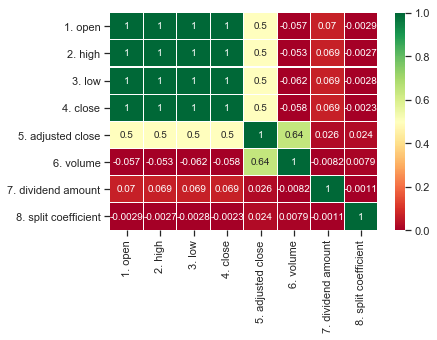

In [30]:
df = df.apply(pd.to_numeric)
sns.heatmap(df.corr(),annot=True,cmap='RdYlGn', linewidths=0.1, vmin=0)

Adjusted close seems to be semi-correlated to Volume. Lets test out if this dependency bodes well for predictions!

In [33]:
correlation = df[['5. adjusted close'] + ['6. volume']].values
scaled = scale.fit_transform(correlation)

prediction = series_to_supervised(scaled, 1, 1)
prediction.drop(prediction.columns[3], axis=1, inplace=True)

vals = prediction.values
train_len = int(len(vals) * 0.7)
train, test = vals[0:train_len, :], vals[train_len:, :]

x_train, y_train = train[:, :-1], train[:, -1]
x_test, y_test = test[:, :-1], test[:, -1]

x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

In [34]:
# using the same parameters as the single feature model + 1 feature
multi_feature = Sequential([LSTM(20, input_shape=(x_train.shape[1], x_train.shape[2]))])
multi_feature.add(Dropout(0.2))
multi_feature.add(Dense(1))
multi_feature.compile(optimizer='adam',loss='mse')
multi_history = multi_feature.fit(x_train, y_train, epochs=70, batch_size=30, validation_data=(x_test,y_test),shuffle=False, verbose=0)


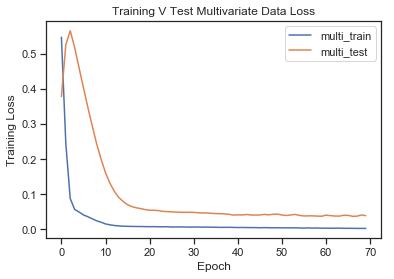

In [35]:
plt.plot(multi_history.history['loss'], label='multi_train')
plt.plot(multi_history.history['val_loss'], label='multi_test')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training V Test Multivariate Data Loss')
plt.legend()
plt.show()

Looking at the multivariate graph for data loss, it is apparent that the number of epochs doesn't converge as readily as its univariate counterpart.  In fact, it didn't get nearly as close, even when increasing the number to 70.  

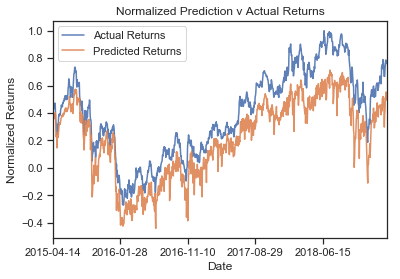

In [36]:
yhat = multi_feature.predict(x_test)


real = df[-y_test.shape[0]:]
forecast = pd.DataFrame(yhat,index=real.index).rename({0:'Predicted Returns'},axis=1)
actually = pd.DataFrame(y_test, index=real.index).rename({0:'Actual Returns'},axis =1)
multi = actually.merge(forecast, left_index=True, right_index=True)

multi.plot(title='Normalized Prediction v Actual Returns', alpha=0.9)
plt.xlabel('Date')
plt.ylabel('Normalized Returns')
plt.show()

In [37]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[2]))

inv_yhat = np.concatenate((yhat, x_test[:, 1:]), axis = 1)
inv_yhat = scale.inverse_transform(inv_yhat)
inv_yhat= inv_yhat[:,0]
inv_yhat

y_test = np.reshape(y_test, (y_test.shape[0], 1))
inv_y = np.concatenate((y_test, x_test[:, 1:]), axis = 1)
inv_y = scale.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [38]:
#Root Mean Squared Error
rmse = round(np.sqrt(mean_squared_error(inv_y,inv_yhat)),3)
print('Test RMSE: {0:.{1}f}'.format(rmse,3))

Test RMSE: 8.693


When playing with the epoch input (50-100) for this experiment, we managed to get the RMSE down to ~2.3 with 100 epochs. Ecstatic, we seemingly had come to the conclusion that a multivariate experiment with more epochs was more effective than the univariate test.  However, upon closer analysis, it seemed that due to the increased number of epochs, we were overfitting the data.  We added in a Dropout layer to randomly remove nodes each update cycle.  This confirmed our fears - we were in fact, overfitting the data.  Interestingly enough, the RMSE for the univariate model stayed roughly the same, only changing by ~0.5, whereas the multivariate RMSE jumped up to the value you see above.  

It is possible be that a multivariate approach isn't as efficient as we had hoped.  It could also be that our model is incorrect, the stock we chose was a poor one for this specific analysis.  

#### Concluding Remarks
In conclusion, we've shown the power of statistical methods and big data in finance, and the promise of what may come as technological advances continue to come. We successfully compiled and analyzed market, sector, and industry ETFs over the past 7 years. We were able to explain movement in their values due to geopolitical forces by processing political and business articles, and we ended by constructing an optimized portfolio based off of our assets to maximize our return while minimizing our risk. 

We ended by showing the power that Long Short-Term Memory RNN's have when it comes to forecasting time series data. We were able to obtain a root mean squared error of approximately 3.5 when testing with optimized parameters found through a grid search of possible candidates. Using this, we made forecasts using a combination of a stocks price and volume. Interestingly enough, adding volume as a feature did not increase the accuracy of our prediction, at least for the Biotech Industry ETF. This goes to show how the trickiest part of building any model is feature engineering. While volume was not an ideal candidate, there are a host of other factors, both technical and fundamental, that one could apply with hopes of improving prediction quality. We leave these endeavors to the reader as a future exercise!

### References:

[1] https://www.bloomberg.com/graphics/2018-shrinking-hedge-fund/

[2] https://www.investopedia.com/terms/e/etf.asp

[3] https://www.alphavantage.co/

[4] https://money.cnn.com/2015/12/31/investing/stocks-market-end-of-2015/index.html

[5] https://www.investopedia.com/articles/stocks/06/biotechvaluation.asp

[6] https://www.investopedia.com/articles/technical/102201.asp

[7] https://en.wikipedia.org/wiki/Modern_portfolio_theory#Efficient_frontier_with_no_risk-free_asset

[8] https://towardsdatascience.com/recurrent-neural-networks-and-lstm-4b601dd822a5